In [8]:
import heapq
import time
import math
from copy import deepcopy
from typing import List, Tuple, Optional, Dict
from IPython.display import display, clear_output
import matplotlib.pyplot as plt
from matplotlib import patches
import numpy as np
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

In [3]:
class Node:
    """节点类，表示十五数码问题的一个状态"""
    def __init__(self, state: List[List[int]], parent=None, move=None, g=0, h=0):
        """
        初始化节点
        Args:
            state: 4x4的二维列表，表示当前状态，0代表空白
            parent: 父节点
            move: 从父节点到当前节点的移动方向
            g: 从起始节点到当前节点的实际代价
            h: 从当前节点到目标节点的启发式估计代价
        """
        self.state = state
        self.parent = parent
        self.move = move  # 移动方向：'U', 'D', 'L', 'R'
        self.g = g  # 路径成本
        self.h = h  # 启发式估计
        self.f = g + h  # 总成本

    def __lt__(self, other):
        """用于堆排序，比较节点的f值"""
        return self.f < other.f or (self.f == other.f and self.h < other.h)

    def __eq__(self, other):
        """判断两个节点状态是否相同"""
        if not isinstance(other, Node):
            return False
        return self.state == other.state

    def __hash__(self):
        """将状态转换为元组以便哈希"""
        return hash(tuple(tuple(row) for row in self.state))

    def get_blank_position(self) -> Tuple[int, int]:
        """获取空白格子的位置"""
        for i in range(4):
            for j in range(4):
                if self.state[i][j] == 0:
                    return i, j
        return None

class FifteenPuzzleSolver:
    """十五数码问题求解器"""

    # 目标状态
    GOAL_STATE = [
        [1, 2, 3, 4],
        [5, 6, 7, 8],
        [9, 10, 11, 12],
        [13, 14, 15, 0]
    ]

    def __init__(self, initial_state: List[List[int]], heuristic_type='manhattan'):
        """
        初始化求解器
        Args:
            initial_state: 初始状态
            heuristic_type: 启发函数类型 ('manhattan' 或 'misplaced')
        """
        self.initial_state = initial_state
        self.heuristic_type = heuristic_type
        self.nodes_expanded = 0  # 扩展节点数
        self.nodes_generated = 0  # 生成节点数
        self.solution_path = []  # 解决方案路径
        self.solution_moves = []  # 解决方案移动序列
        self.runtime = 0  # 运行时间
        self.max_depth = 0  # 最大搜索深度

    def is_solvable(self, state: List[List[int]]) -> bool:
        """
        判断给定的十五数码状态是否可解
        基于逆序数的奇偶性判断
        """
        # 将4x4矩阵展平为一维列表，排除空白（0）
        flat_state = []
        for i in range(4):
            for j in range(4):
                if state[i][j] != 0:
                    flat_state.append(state[i][j])

        # 计算逆序数
        inversions = 0
        for i in range(len(flat_state)):
            for j in range(i + 1, len(flat_state)):
                if flat_state[i] > flat_state[j]:
                    inversions += 1

        # 找到空白格所在行（从下往上数，从1开始）
        blank_row = 0
        for i in range(4):
            for j in range(4):
                if state[i][j] == 0:
                    blank_row = 4 - i  # 从底部计数的行数
                    break

        # 对于4x4的十五数码：
        # 如果空白在从底部计数的偶数行，逆序数需为奇数才可解
        # 如果空白在从底部计数的奇数行，逆序数需为偶数才可解
        if (blank_row % 2 == 0) and (inversions % 2 == 1):
            return True
        elif (blank_row % 2 == 1) and (inversions % 2 == 0):
            return True
        else:
            return False

    def heuristic(self, state: List[List[int]]) -> int:
        """计算启发式函数值"""
        if self.heuristic_type == 'manhattan':
            return self.manhattan_distance(state)
        elif self.heuristic_type == 'misplaced':
            return self.misplaced_tiles(state)
        elif self.heuristic_type == 'euclidean':
            return self.euclidean_distance(state)
        else:
            raise ValueError(f"Unknown heuristic type: {self.heuristic_type}")

    def manhattan_distance(self, state: List[List[int]]) -> int:
        """
        曼哈顿距离启发函数
        计算每个数字当前位置到目标位置的曼哈顿距离之和
        """
        distance = 0
        for i in range(4):
            for j in range(4):
                if state[i][j] != 0:  # 忽略空白格
                    value = state[i][j]
                    # 计算目标位置
                    target_row = (value - 1) // 4
                    target_col = (value - 1) % 4
                    # 计算曼哈顿距离
                    distance += abs(i - target_row) + abs(j - target_col)
        return distance

    def misplaced_tiles(self, state: List[List[int]]) -> int:
        """
        不在位元素个数启发函数
        计算不在正确位置上的数字个数（不包括空白格）
        """
        count = 0
        for i in range(4):
            for j in range(4):
                if state[i][j] != 0:  # 忽略空白格
                    if state[i][j] != self.GOAL_STATE[i][j]:
                        count += 1
        return count

    def euclidean_distance(self, state: List[List[int]]) -> float:
        """
        欧几里得距离启发函数
        计算每个数字当前位置到目标位置的欧几里得距离之和
        """
        distance = 0.0
        for i in range(4):
            for j in range(4):
                if state[i][j] != 0:  # 忽略空白格
                    value = state[i][j]
                    # 计算目标位置
                    target_row = (value - 1) // 4
                    target_col = (value - 1) % 4
                    # 计算欧几里得距离
                    distance += math.sqrt((i - target_row)**2 + (j - target_col)**2)
        return distance

    def get_neighbors(self, node: Node) -> List[Node]:
        """获取当前节点的所有可能后继节点"""
        neighbors = []
        i, j = node.get_blank_position()

        # 定义四个方向的移动
        moves = [
            ('U', i-1, j),  # 上
            ('D', i+1, j),  # 下
            ('L', i, j-1),  # 左
            ('R', i, j+1)   # 右
        ]

        for move, new_i, new_j in moves:
            # 检查移动是否合法
            if 0 <= new_i < 4 and 0 <= new_j < 4:
                # 创建新状态
                new_state = deepcopy(node.state)
                # 交换空白格和相邻格子
                new_state[i][j], new_state[new_i][new_j] = new_state[new_i][new_j], new_state[i][j]

                # 创建新节点
                new_node = Node(
                    state=new_state,
                    parent=node,
                    move=move,
                    g=node.g + 1,
                    h=self.heuristic(new_state)
                )
                neighbors.append(new_node)
                self.nodes_generated += 1

        return neighbors

    def a_star_search(self) -> Tuple[bool, Optional[Node]]:
        """执行A*搜索算法"""
        start_time = time.time()

        # 检查是否可解
        if not self.is_solvable(self.initial_state):
            print("该初始状态无解！")
            self.runtime = time.time() - start_time
            return False, None

        # 初始化起始节点
        start_node = Node(
            state=self.initial_state,
            parent=None,
            move=None,
            g=0,
            h=self.heuristic(self.initial_state)
        )
        self.nodes_generated = 1

        # 初始化开放列表（优先队列）和关闭列表
        open_list = []
        closed_set = set()

        # 将起始节点加入开放列表
        heapq.heappush(open_list, start_node)

        while open_list:
            # 获取f值最小的节点
            current_node = heapq.heappop(open_list)

            # 检查是否达到目标状态
            if current_node.state == self.GOAL_STATE:
                self.runtime = time.time() - start_time
                self.nodes_expanded = len(closed_set)
                return True, current_node

            # 将当前节点加入关闭列表
            current_state_hash = hash(current_node)
            if current_state_hash in closed_set:
                continue
            closed_set.add(current_state_hash)

            # 扩展当前节点
            neighbors = self.get_neighbors(current_node)
            self.nodes_expanded += 1

            # 更新最大深度
            self.max_depth = max(self.max_depth, current_node.g)

            for neighbor in neighbors:
                # 如果邻居节点已经在关闭列表中，跳过
                if hash(neighbor) in closed_set:
                    continue

                # 检查开放列表中是否已有该状态，如果有且代价更高，则更新
                found_in_open = False
                for i, open_node in enumerate(open_list):
                    if open_node.state == neighbor.state:
                        found_in_open = True
                        if neighbor.g < open_node.g:
                            # 更新节点的代价
                            open_list[i] = neighbor
                            heapq.heapify(open_list)
                        break

                # 如果不在开放列表中，加入
                if not found_in_open:
                    heapq.heappush(open_list, neighbor)

        self.runtime = time.time() - start_time
        return False, None

    def solve(self) -> bool:
        """求解十五数码问题"""
        success, goal_node = self.a_star_search()

        if success:
            # 回溯得到解决方案路径
            self.solution_path = []
            self.solution_moves = []
            current = goal_node

            while current.parent is not None:
                self.solution_path.append(current.state)
                self.solution_moves.append(current.move)
                current = current.parent

            # 添加初始状态并反转列表
            self.solution_path.append(current.state)
            self.solution_path.reverse()
            self.solution_moves.reverse()

            return True
        else:
            return False

    def print_statistics(self):
        """打印求解统计信息"""
        print("\n" + "="*60)
        print("求解统计信息")
        print("="*60)
        print(f"初始状态是否可解: {'是' if self.is_solvable(self.initial_state) else '否'}")
        print(f"是否找到解决方案: {'是' if self.solution_path else '否'}")
        print(f"扩展节点数: {self.nodes_expanded}")
        print(f"生成节点数: {self.nodes_generated}")
        print(f"解决方案步数: {len(self.solution_moves)}")
        print(f"最大搜索深度: {self.max_depth}")
        print(f"运行时间: {self.runtime:.4f} 秒")
        print(f"启发函数类型: {self.heuristic_type}")

        if self.solution_moves:
            print(f"移动序列: {' → '.join(self.solution_moves)}")
            print(f"移动序列详情: {self._get_move_names()}")
        print("="*60)

    def _get_move_names(self):
        """将移动序列转换为可读的名称"""
        move_names = {
            'U': '↑',
            'D': '↓',
            'L': '←',
            'R': '→'
        }
        return ' '.join([move_names.get(move, move) for move in self.solution_moves])

    def print_state(self, state: List[List[int]], title=""):
        """打印状态"""
        if title:
            print(f"\n{title}:")
        print("+" + "-"*25 + "+")
        for i in range(4):
            print("|", end=" ")
            for j in range(4):
                if state[i][j] == 0:
                    print(f"{' ':4s}", end=" ")
                else:
                    print(f"{state[i][j]:4d}", end=" ")
            print("|")
        print("+" + "-"*25 + "+")

In [12]:
def visualize_puzzle(state, title="", ax=None):
    """可视化十五数码状态"""
    if ax is None:
        fig, ax = plt.subplots(figsize=(6, 6))

    # 清除之前的图形
    ax.clear()

    # 设置坐标轴
    ax.set_xlim(0, 4)
    ax.set_ylim(0, 4)
    ax.set_xticks(range(5))
    ax.set_yticks(range(5))
    ax.grid(True, linestyle='-', linewidth=2, color='black')
    ax.set_aspect('equal')

    # 隐藏坐标轴刻度
    ax.set_xticklabels([])
    ax.set_yticklabels([])

    # 绘制每个格子
    for i in range(4):
        for j in range(4):
            value = state[i][j]
            # 计算格子的中心位置
            x_center = j + 0.5
            y_center = 3.5 - i  # 反转y轴方向

            # 绘制格子背景
            if value == 0:
                # 空白格
                rect = patches.Rectangle((j, 3-i), 1, 1,
                                        facecolor='lightgray',
                                        edgecolor='black',
                                        linewidth=2)
                ax.add_patch(rect)
                # 添加"空白"文本
                ax.text(x_center, y_center, "空白",
                       ha='center', va='center',
                       fontsize=12, fontweight='bold')
            else:
                # 数字格
                rect = patches.Rectangle((j, 3-i), 1, 1,
                                        facecolor='lightblue',
                                        edgecolor='black',
                                        linewidth=2)
                ax.add_patch(rect)
                # 添加数字文本
                ax.text(x_center, y_center, str(value),
                       ha='center', va='center',
                       fontsize=14, fontweight='bold')

    # 设置标题
    ax.set_title(title, fontsize=16, fontweight='bold', pad=20)

    plt.tight_layout()
    return ax

def visualize_solution_interactive(solver, delay=0.5):
    """在Jupyter Notebook中交互式可视化解决方案"""
    if not solver.solution_path:
        print("无解决方案可展示")
        return

    fig, ax = plt.subplots(figsize=(6, 6))

    for step, state in enumerate(solver.solution_path):
        # 清除之前的输出
        clear_output(wait=True)

        if step == 0:
            title = "初始状态"
        else:
            move = solver.solution_moves[step-1]
            move_name = {'U': '上移', 'D': '下移', 'L': '左移', 'R': '右移'}.get(move, move)
            title = f"第 {step} 步: {move_name} ({move})"

        # 绘制当前状态
        ax = visualize_puzzle(state, title, ax)

        # 显示当前步数和总步数
        plt.figtext(0.5, 0.01, f"步骤 {step}/{len(solver.solution_path)-1}",
                   ha='center', fontsize=12, fontweight='bold')

        display(fig)

        # 如果不是最后一步，等待一下
        if step < len(solver.solution_path) - 1:
            time.sleep(delay)

    # 最后一步保持显示
    plt.show()

def create_test_cases():
    """创建测试实例"""
    test_cases = {}

    # 简单实例（3步解决）
    test_cases['简单'] = [
        [1, 2, 3, 4],
        [5, 6, 7, 8],
        [9, 10, 11, 12],
        [13, 14, 0, 15]
    ]

    # 中等难度实例
    test_cases['中等'] = [
        [1, 2, 3, 4],
        [5, 6, 7, 8],
        [9, 10, 0, 11],
        [13, 14, 15, 12]
    ]

    # 较难实例（需要更多步骤）
    test_cases['困难'] = [
        [1, 2, 3, 4],
        [5, 6, 7, 8],
        [9, 0, 10, 12],
        [13, 14, 11, 15]
    ]

    # 挑战性实例
    test_cases['挑战'] = [
        [0, 2, 3, 4],
        [1, 6, 7, 8],
        [5, 10, 11, 12],
        [9, 13, 14, 15]
    ]

    # 无解实例（不可解）
    test_cases['无解'] = [
        [1, 2, 3, 4],
        [5, 6, 7, 8],
        [9, 10, 11, 12],
        [13, 15, 14, 0]
    ]

    return test_cases

def plot_heuristic_comparison():
    """绘制不同启发函数的性能比较"""
    test_cases = create_test_cases()
    heuristics = ['manhattan', 'misplaced', 'euclidean']

    # 排除无解实例
    test_cases_filtered = {k: v for k, v in test_cases.items() if k != '无解'}

    results = []
    for test_name, state in test_cases_filtered.items():
        for heuristic in heuristics:
            solver = FifteenPuzzleSolver(state, heuristic_type=heuristic)
            if solver.is_solvable(state):
                start_time = time.time()
                success = solver.solve()
                end_time = time.time()

                if success:
                    results.append({
                        'test': test_name,
                        'heuristic': heuristic,
                        'time': end_time - start_time,
                        'expanded': solver.nodes_expanded,
                        'steps': len(solver.solution_moves)
                    })

    # 创建图形
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))

    # 1. 运行时间比较
    ax1 = axes[0, 0]
    for heuristic in heuristics:
        times = [r['time'] for r in results if r['heuristic'] == heuristic]
        tests = [r['test'] for r in results if r['heuristic'] == heuristic]
        ax1.plot(tests, times, marker='o', label=heuristic, linewidth=2)
    ax1.set_title('运行时间比较', fontsize=14, fontweight='bold')
    ax1.set_xlabel('测试实例', fontsize=12)
    ax1.set_ylabel('时间 (秒)', fontsize=12)
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # 2. 扩展节点数比较
    ax2 = axes[0, 1]
    for heuristic in heuristics:
        expanded = [r['expanded'] for r in results if r['heuristic'] == heuristic]
        tests = [r['test'] for r in results if r['heuristic'] == heuristic]
        ax2.bar([f"{t}\n{h}" for t, h in zip(tests, [heuristic]*len(tests))],
                expanded, label=heuristic, alpha=0.7)
    ax2.set_title('扩展节点数比较', fontsize=14, fontweight='bold')
    ax2.set_xlabel('测试实例和启发函数', fontsize=12)
    ax2.set_ylabel('扩展节点数', fontsize=12)
    ax2.tick_params(axis='x', rotation=45)

    # 3. 解决方案步数比较
    ax3 = axes[1, 0]
    steps_data = {}
    for test_name in test_cases_filtered.keys():
        steps_data[test_name] = []
        for heuristic in heuristics:
            step = next((r['steps'] for r in results if r['test'] == test_name and r['heuristic'] == heuristic), 0)
            steps_data[test_name].append(step)

    x = np.arange(len(heuristics))
    width = 0.2
    multiplier = 0

    for test_name, steps in steps_data.items():
        offset = width * multiplier
        ax3.bar(x + offset, steps, width, label=test_name)
        multiplier += 1

    ax3.set_title('解决方案步数比较', fontsize=14, fontweight='bold')
    ax3.set_xlabel('启发函数', fontsize=12)
    ax3.set_ylabel('步数', fontsize=12)
    ax3.set_xticks(x + width, heuristics)
    ax3.legend(loc='upper right', ncol=2)

    # 4. 性能综合图
    ax4 = axes[1, 1]
    heuristic_performance = {}
    for heuristic in heuristics:
        total_time = sum(r['time'] for r in results if r['heuristic'] == heuristic)
        total_expanded = sum(r['expanded'] for r in results if r['heuristic'] == heuristic)
        heuristic_performance[heuristic] = {
            'time': total_time,
            'expanded': total_expanded
        }

    metrics = ['时间', '扩展节点']
    x_pos = np.arange(len(metrics))

    for i, heuristic in enumerate(heuristics):
        values = [heuristic_performance[heuristic]['time'],
                 heuristic_performance[heuristic]['expanded'] / 1000]  # 除以1000以便在同一图表中显示
        ax4.plot(x_pos, values, marker='o', label=heuristic, linewidth=2)

    ax4.set_title('启发函数性能综合比较', fontsize=14, fontweight='bold')
    ax4.set_xlabel('指标', fontsize=12)
    ax4.set_ylabel('值 (时间:秒, 扩展节点:千)', fontsize=12)
    ax4.set_xticks(x_pos)
    ax4.set_xticklabels(metrics)
    ax4.legend()
    ax4.grid(True, alpha=0.3)

    plt.suptitle('十五数码问题A*算法性能分析', fontsize=16, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.show()

    return results

In [5]:
def demo_fifteen_puzzle():
    """演示十五数码问题的求解过程"""
    print("="*60)
    print("十五数码问题求解演示")
    print("="*60)

    # 创建测试实例
    test_cases = create_test_cases()

    # 选择中等难度实例
    initial_state = test_cases['中等']

    print("初始状态:")
    solver = FifteenPuzzleSolver(initial_state, heuristic_type='manhattan')
    solver.print_state(initial_state)

    # 检查可解性
    is_solvable = solver.is_solvable(initial_state)
    print(f"\n可解性检查: {'可解' if is_solvable else '不可解'}")

    if is_solvable:
        # 求解
        print("\n正在使用A*算法求解...")
        start_time = time.time()
        success = solver.solve()
        end_time = time.time()

        if success:
            print(f"求解成功! 耗时: {end_time-start_time:.4f}秒")

            # 显示统计信息
            solver.print_statistics()

            # 询问是否可视化
            print("\n是否可视化解决方案? (输入 'y' 确认，其他跳过): ")
            visualize = input().strip().lower()

            if visualize == 'y':
                print("开始可视化解决方案...")
                visualize_solution_interactive(solver, delay=0.8)
        else:
            print("求解失败!")
    else:
        print("该初始状态无解!")

def compare_heuristics_demo():
    """比较不同启发函数的性能"""
    print("="*60)
    print("不同启发函数性能比较")
    print("="*60)

    # 创建测试实例
    test_cases = create_test_cases()

    # 选择中等难度实例
    initial_state = test_cases['中等']

    print("测试实例: 中等难度")
    solver = FifteenPuzzleSolver(initial_state)
    solver.print_state(initial_state)

    results = []
    heuristics = ['manhattan', 'misplaced', 'euclidean']

    for heuristic in heuristics:
        print(f"\n使用启发函数: {heuristic}")
        solver = FifteenPuzzleSolver(initial_state, heuristic_type=heuristic)

        if solver.is_solvable(initial_state):
            start_time = time.time()
            success = solver.solve()
            end_time = time.time()

            if success:
                print(f"  解决方案步数: {len(solver.solution_moves)}")
                print(f"  扩展节点数: {solver.nodes_expanded}")
                print(f"  生成节点数: {solver.nodes_generated}")
                print(f"  运行时间: {end_time-start_time:.4f}秒")

                results.append({
                    'heuristic': heuristic,
                    'steps': len(solver.solution_moves),
                    'expanded': solver.nodes_expanded,
                    'time': end_time-start_time
                })
            else:
                print("  求解失败!")
        else:
            print("  该实例无解!")

    # 显示比较结果
    print("\n" + "="*60)
    print("性能比较汇总")
    print("="*60)
    print(f"{'启发函数':<12} {'步数':<8} {'扩展节点':<12} {'时间(秒)':<10}")
    print("-"*60)

    for result in results:
        print(f"{result['heuristic']:<12} {result['steps']:<8} {result['expanded']:<12} {result['time']:<10.4f}")

    # 绘制比较图表
    plot_heuristic_comparison()

def interactive_solver():
    """交互式求解器"""
    print("="*60)
    print("交互式十五数码求解器")
    print("="*60)

    # 创建测试实例
    test_cases = create_test_cases()

    # 显示可用的测试实例
    print("可用的测试实例:")
    for i, (name, state) in enumerate(test_cases.items(), 1):
        print(f"{i}. {name}")

    print(f"{len(test_cases)+1}. 自定义输入")

    try:
        choice = int(input("\n请选择测试实例 (输入序号): "))

        if 1 <= choice <= len(test_cases):
            test_names = list(test_cases.keys())
            selected_test = test_names[choice-1]
            initial_state = test_cases[selected_test]
        elif choice == len(test_cases) + 1:
            # 自定义输入
            print("\n自定义输入模式")
            print("请输入4x4的十五数码状态（用空格分隔数字，0表示空白）")
            print("示例: 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 0")

            input_str = input("\n请输入16个数字: ")
            numbers = list(map(int, input_str.strip().split()))

            if len(numbers) != 16:
                print("错误: 需要16个数字!")
                return

            # 转换为4x4矩阵
            initial_state = [numbers[i:i+4] for i in range(0, 16, 4)]
            selected_test = "自定义"
        else:
            print("无效选择，使用默认实例")
            initial_state = test_cases['中等']
            selected_test = '中等'
    except:
        print("无效输入，使用默认实例")
        initial_state = test_cases['中等']
        selected_test = '中等'

    # 选择启发函数
    print("\n选择启发函数:")
    print("1. 曼哈顿距离 (推荐)")
    print("2. 不在位元素个数")
    print("3. 欧几里得距离")

    try:
        heuristic_choice = int(input("请选择启发函数 (输入序号): "))
        if heuristic_choice == 1:
            heuristic_type = 'manhattan'
        elif heuristic_choice == 2:
            heuristic_type = 'misplaced'
        elif heuristic_choice == 3:
            heuristic_type = 'euclidean'
        else:
            print("无效选择，使用曼哈顿距离")
            heuristic_type = 'manhattan'
    except:
        print("无效输入，使用曼哈顿距离")
        heuristic_type = 'manhattan'

    # 创建求解器
    print(f"\n求解实例: {selected_test}")
    print(f"使用启发函数: {heuristic_type}")

    solver = FifteenPuzzleSolver(initial_state, heuristic_type=heuristic_type)

    # 显示初始状态
    print("\n初始状态:")
    solver.print_state(initial_state)

    # 检查可解性
    is_solvable = solver.is_solvable(initial_state)
    print(f"\n可解性检查: {'可解' if is_solvable else '不可解'}")

    if not is_solvable:
        print("该初始状态无解!")
        return

    # 求解
    print("\n正在使用A*算法求解...")
    start_time = time.time()
    success = solver.solve()
    end_time = time.time()

    if success:
        print(f"求解成功! 耗时: {end_time-start_time:.4f}秒")

        # 显示统计信息
        solver.print_statistics()

        # 询问是否可视化
        print("\n是否可视化解决方案? (输入 'y' 确认，其他跳过): ")
        visualize = input().strip().lower()

        if visualize == 'y':
            print("开始可视化解决方案...")
            visualize_solution_interactive(solver, delay=0.8)

        # 询问是否显示详细步骤
        print("\n是否显示详细步骤? (输入 'y' 确认，其他跳过): ")
        show_details = input().strip().lower()

        if show_details == 'y':
            print("\n详细步骤:")
            for i, (step_state, move) in enumerate(zip(solver.solution_path, ['初始'] + solver.solution_moves)):
                if i == 0:
                    solver.print_state(step_state, "初始状态")
                else:
                    move_name = {'U': '上移', 'D': '下移', 'L': '左移', 'R': '右移'}.get(move, move)
                    solver.print_state(step_state, f"第 {i} 步: {move_name}")
    else:
        print("求解失败!")

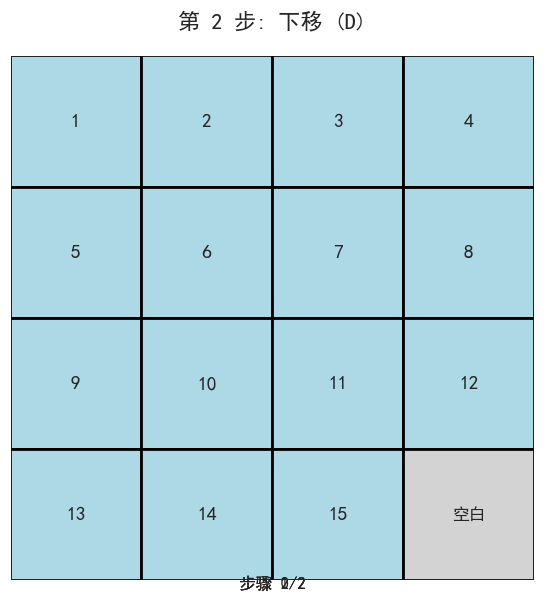

In [13]:
# 运行此单元格来启动交互式求解器
if __name__ == "__main__":
    print("欢迎使用十五数码问题求解器!")
    print("\n请选择演示模式:")
    print("1. 基本演示")
    print("2. 启发函数比较")
    print("3. 交互式求解器")

    try:
        mode = int(input("\n请输入选择 (1-3): "))

        if mode == 1:
            demo_fifteen_puzzle()
        elif mode == 2:
            compare_heuristics_demo()
        elif mode == 3:
            interactive_solver()
        else:
            print("无效选择，运行基本演示")
            demo_fifteen_puzzle()
    except:
        print("无效输入，运行基本演示")
        demo_fifteen_puzzle()